C:\Users\user\anaconda3\ana\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
C:\Users\user\anaconda3\ana\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\user\anaconda3\ana\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.7556 - loss: 0.4961 - val_accuracy: 0.8835 - val_loss: 0.2585
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 188s 978ms/step - accuracy: 0.8788 - loss: 0.3141 - val_accuracy: 0.8948 - val_loss: 0.2370
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 157s 815ms/step - accuracy: 0.8950 - loss: 0.2689 - val_accuracy: 0.9193 - val_loss: 0.1943
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 157s 817ms/step - accuracy: 0.9098 - loss: 0.2248 - val_accuracy: 0.9265 - val_loss: 0.1885
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 158s 822ms/step - accuracy: 0.9189 - loss: 0.2058 - val_accuracy: 0.9510 - val_loss: 0.1365
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 158s 821ms/step - accuracy: 0.9269 - loss: 0.1998 - val_accuracy: 0.9378 - val_loss: 0.1679
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 156s 814ms/step - accuracy: 0.9253 - loss: 0.1970 - val_accuracy: 0.9451 - val_loss: 0.1396
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 154s 804ms/step - accuracy: 0.9336 - loss: 0.1736 

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9530 - loss: 0.1259
Test Accuracy = 0.9569821357727051


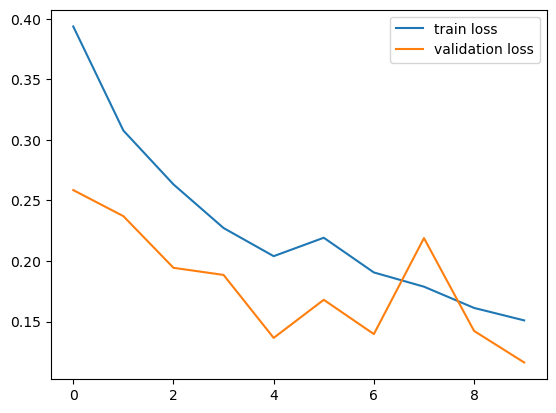

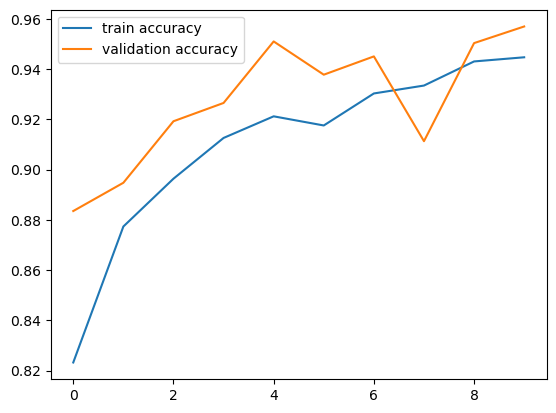

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step
Classification Report:
               precision    recall  f1-score   support

Without Mask       0.93      0.99      0.96       768
   With Mask       0.98      0.93      0.95       743

    accuracy                           0.96      1511
   macro avg       0.96      0.96      0.96      1511
weighted avg       0.96      0.96      0.96      1511



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Load dataset
with_mask_files = os.listdir('data/with_mask')
without_mask_files = os.listdir('data/without_mask')

# Create labels
with_mask_labels = [1] * len(with_mask_files)
without_mask_labels = [0] * len(without_mask_files)
labels = with_mask_labels + without_mask_labels

# Convert images to numpy arrays
with_mask_path = 'data/with_mask/'
without_mask_path = 'data/without_mask/'
data = []

def preprocess_image(img_file, path):
    image = Image.open(path + img_file)
    image = image.resize((128, 128))
    image = image.convert('RGB')
    image = np.array(image)
    return image

data.extend([preprocess_image(img, with_mask_path) for img in with_mask_files])
data.extend([preprocess_image(img, without_mask_path) for img in without_mask_files])

X = np.array(data)
Y = np.array(labels)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Scale the data
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

# Updated model architecture
num_of_classes = 2
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_of_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train_scaled)

history = model.fit(datagen.flow(X_train_scaled, Y_train, batch_size=32), 
                    validation_data=(X_test_scaled, Y_test), 
                    epochs=10)

# Save the model
model.save('faceee_detection_model.h5')

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy)

# Plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Display classification report
Y_pred_probs = model.predict(X_test_scaled)
Y_pred = np.argmax(Y_pred_probs, axis=1)
report = classification_report(Y_test, Y_pred, target_names=['Without Mask', 'With Mask'])
print("Classification Report:\n", report)


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import Label
from playsound import playsound
import threading
import os
import datetime
import csv
import base64

# Load the saved model
model = tf.keras.models.load_model('faceee_detection_model.h5')

# Function to preprocess image
def preprocess_image(img):
    img = img.resize((128, 128))
    img = img.convert('RGB')
    img_array = image.img_to_array(img)
    img_scaled = img_array / 255.0
    img_reshaped = np.expand_dims(img_scaled, axis=0)
    return img_reshaped

# Function to predict mask status
def predict_mask(img):
    img_reshaped = preprocess_image(img)
    prediction = model.predict(img_reshaped)
    pred_label = np.argmax(prediction)
    return 'Wearing Mask' if pred_label == 1 else 'Not Wearing Mask'

# Function to play warning sound
def play_warning_sound():
    playsound(os.path.abspath('mixkit-classic-alarm-995.wav'))

# Function to convert image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

# Function to save image when no mask is detected
def save_unmasked_image(frame):
    if not os.path.exists('unmasked'):
        os.makedirs('unmasked')
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    image_filename = os.path.join('unmasked', f'unmasked_{timestamp}.jpg')
    cv2.imwrite(image_filename, frame)

    # Convert image to Base64
    image_base64 = image_to_base64(image_filename)

    # Save the timestamp and Base64 image to a CSV file
    csv_file_path = os.path.join('unmasked', 'images.csv')
    file_exists = os.path.isfile(csv_file_path)
    with open(csv_file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        if not file_exists:
            csvwriter.writerow(['Timestamp', 'Image Filename', 'Base64 Image'])  # Write header if file is new
        csvwriter.writerow([timestamp, image_filename, image_base64])

# Function to update frame in the GUI
def update_frame():
    if not cap.isOpened():
        return

    ret, frame = cap.read()
    if not ret:
        return

    # Convert the image to a format suitable for Tkinter
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    prediction = predict_mask(img)
    
    # Play warning sound if no mask is detected
    if prediction == 'Not Wearing Mask':
        threading.Thread(target=play_warning_sound).start()
        save_unmasked_image(frame)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # Draw rectangles around the detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Convert the updated frame back to an image suitable for Tkinter
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img_tk = ImageTk.PhotoImage(image=img)
    
    # Update the GUI elements
    label_img.config(image=img_tk)
    label_img.image = img_tk
    label_pred.config(text=prediction)
    
    # Repeat after 10 ms
    root.after(10, update_frame)

# Function to open the webcam
def open_webcam():
    global cap
    cap.open(0)
    update_frame()

# Function to close the webcam
def close_webcam():
    global cap
    if cap.isOpened():
        cap.release()
    label_img.config(image='')
    label_pred.config(text='Webcam closed')

# Initialize the main window
root = tk.Tk()
root.title("Real-time Mask Detection")

# Set up the webcam (initially closed)
cap = cv2.VideoCapture()
cap.release()

# Load the face cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Create and place GUI elements using grid layout
label_img = Label(root)
label_img.grid(row=0, column=0, columnspan=2)
label_pred = Label(root, text="Click 'Open Webcam' to start", font=("Helvetica", 16))
label_pred.grid(row=1, column=0, columnspan=2, pady=(10, 20))

# Create buttons to open and close the webcam and place them in the center
btn_open = tk.Button(root, text="Open Webcam", command=open_webcam)
btn_open.grid(row=2, column=0, pady=10, padx=(20, 10))
btn_close = tk.Button(root, text="Close Webcam", command=close_webcam)
btn_close.grid(row=2, column=1, pady=10, padx=(10, 20))

# Start the Tkinter main loop
root.mainloop()

# Release the webcam and destroy windows when done
if cap.isOpened():
    cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━